# Challenge Large Scale Machine Learning

## Authors:

Pavlo Mozharovskyi (pavlo.mozharovskyi@telecom-paris.fr), Umut Şimşekli (umut.simsekli@telecom-paris.fr)

## Fusion of algorithms for face recognition

The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image.

Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

You are provided a label set of training data and a test set without labels. You should submit a .csv file with labels for each entry of this test set.

# The properties of the dataset:

## Training data:

The training set consist of two files, xtrain_challenge.csv and ytrain_challenge.csv.

File xtrain_challenge.csv contains one observation per row which contains following entries based on a pair of images:

columns 1-13 - 13 qualities on first image;
columns 14-26 - 13 qualities on second image;
columns 27-37 - 11 matching scores between the two images.
File ytrain_challenge.csv contains one line with each entry corresponding to one observation in xtrain_challenge.csv, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.

There are in total 1.068.504 training observations.

## Test data:

File xtest_challenge.csv has the same structure as file xtrain_challenge.csv.

There are in total 3.318.296 test observations.

## The performance criterion

The performance criterion is the prediction accuracy on the test set, which is a value between 0 and 1, the higher the better.

In [1]:
# Packages loading
%matplotlib inline
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_val_score, KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC,SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import feature_selection
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import decomposition
from sklearn.metrics import precision_score

from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings("ignore")


### Load the dataset

In [2]:
X = pd.read_csv('xtrain_challenge.csv')
y = pd.read_csv('ytrain_challenge.csv')

In [3]:
X.shape

(1068504, 37)

In [4]:
X.head()

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,...,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11
0,1.0,0.0,0.0,-3.45,-13.14,1.33,0.27,0.99,2.01,212.61,...,6451.89,7382.84,6075.20,10290.42,6839.45,6782.62,7594.45,6711.65,6664.71,6688.64
1,1.0,0.0,0.0,-2.67,-4.88,7.44,0.94,2.03,0.72,271.53,...,2152.79,3329.34,2793.19,2358.42,2454.09,2905.30,2299.96,2434.24,3009.29,2576.67
2,1.0,0.0,0.0,2.46,7.30,-9.13,1.83,1.17,0.19,359.26,...,1632.99,1729.66,1791.57,1913.13,1983.23,1819.05,1816.75,1902.28,2899.05,1795.84
3,1.0,0.0,0.0,17.31,-5.53,-8.82,1.00,1.87,1.15,283.71,...,2367.91,2601.43,2535.50,1940.38,2301.36,2215.60,2708.72,2524.65,3274.52,3233.94
4,1.0,0.0,0.0,15.76,7.75,5.65,2.49,1.11,1.56,232.08,...,1715.43,2123.74,2386.98,1028.29,1890.42,2035.30,2013.08,2529.66,2941.38,2288.81


In [5]:
y.head()

,y
0,1
1,0
2,0
3,0
4,0


In [6]:
# Check label balance
y['y'].value_counts(normalize=True)

0    0.962945
1    0.037055
Name: y, dtype: float64

#### The dataset is quite unbalanced so we have to use a relevant metric to evaluate our results.

In [7]:
# Let's take a look at what parameters looks like:

X.describe()

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,...,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11
count,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,...,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06,1.068504e+06
mean,9.939110e-01,4.062109e-03,1.981265e-03,-5.638050e-02,-5.566450e+00,-6.719246e-01,1.232389e+00,9.762378e-01,8.354712e-01,2.639817e+02,...,2.202422e+03,2.497274e+03,2.473767e+03,2.169686e+03,2.352165e+03,2.212619e+03,2.306689e+03,2.587349e+03,3.206580e+03,2.585904e+03
std,5.279321e-02,4.387503e-02,2.847684e-02,9.614619e+00,8.812512e+00,4.557793e+00,1.146359e+00,8.715162e-01,7.378927e-01,6.803376e+01,...,7.977498e+02,1.017009e+03,9.813839e+02,1.386482e+03,9.488352e+02,1.079085e+03,1.110563e+03,1.023546e+03,6.179037e+02,8.981083e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-5.685000e+01,-5.143000e+01,-2.640000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.725000e+02,...,8.820100e+02,9.321600e+02,1.122610e+03,2.909400e+02,9.150200e+02,4.346500e+02,5.777800e+02,1.258420e+03,2.304680e+03,1.283390e+03
25%,1.000000e+00,0.000000e+00,0.000000e+00,-3.110000e+00,-1.252000e+01,-2.780000e+00,4.600000e-01,3.400000e-01,3.000000e-01,2.213600e+02,...,1.772090e+03,2.013940e+03,2.016820e+03,1.584630e+03,1.894908e+03,1.718750e+03,1.793940e+03,2.157860e+03,2.923360e+03,2.173520e+03
50%,1.000000e+00,0.000000e+00,0.000000e+00,6.000000e-02,-4.630000e+00,-5.700000e-01,9.700000e-01,7.400000e-01,6.500000e-01,2.688200e+02,...,2.029860e+03,2.267070e+03,2.242830e+03,1.878630e+03,2.132330e+03,1.976860e+03,2.064725e+03,2.359370e+03,3.066800e+03,2.384690e+03
75%,1.000000e+00,0.000000e+00,0.000000e+00,3.260000e+00,1.100000e+00,1.480000e+00,1.690000e+00,1.350000e+00,1.160000e+00,3.122700e+02,...,2.376270e+03,2.613220e+03,2.559810e+03,2.266820e+03,2.463582e+03,2.323122e+03,2.428290e+03,2.633230e+03,3.263193e+03,2.673370e+03
max,1.000000e+00,1.000000e+00,1.000000e+00,5.104000e+01,2.474000e+01,2.503000e+01,3.340000e+01,1.228000e+01,9.360000e+00,4.814200e+02,...,1.042724e+04,1.352429e+04,1.139322e+04,1.834417e+04,1.219225e+04,1.306042e+04,1.402735e+04,1.320572e+04,9.235040e+03,1.117024e+04


In [8]:
Train =  pd.concat([X, y], axis=1)

In [9]:
Train.head()

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,...,s3,s4,s5,s6,s7,s8,s9,s10,s11,y
0,1.0,0.0,0.0,-3.45,-13.14,1.33,0.27,0.99,2.01,212.61,...,7382.84,6075.20,10290.42,6839.45,6782.62,7594.45,6711.65,6664.71,6688.64,1
1,1.0,0.0,0.0,-2.67,-4.88,7.44,0.94,2.03,0.72,271.53,...,3329.34,2793.19,2358.42,2454.09,2905.30,2299.96,2434.24,3009.29,2576.67,0
2,1.0,0.0,0.0,2.46,7.30,-9.13,1.83,1.17,0.19,359.26,...,1729.66,1791.57,1913.13,1983.23,1819.05,1816.75,1902.28,2899.05,1795.84,0
3,1.0,0.0,0.0,17.31,-5.53,-8.82,1.00,1.87,1.15,283.71,...,2601.43,2535.50,1940.38,2301.36,2215.60,2708.72,2524.65,3274.52,3233.94,0
4,1.0,0.0,0.0,15.76,7.75,5.65,2.49,1.11,1.56,232.08,...,2123.74,2386.98,1028.29,1890.42,2035.30,2013.08,2529.66,2941.38,2288.81,0


### Shuffling the dataset for randomness

In [10]:
Train = Train.sample(frac=1)

In [11]:
Train.head()

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,...,s3,s4,s5,s6,s7,s8,s9,s10,s11,y
532776,0.99,0.01,0.0,-25.80,-6.53,3.71,2.40,2.02,0.57,290.32,...,1991.67,2239.89,2232.87,1843.23,1481.36,1858.18,1977.73,3189.24,2356.58,0
253164,1.00,0.00,0.0,0.38,-1.23,0.88,0.27,0.68,0.07,337.50,...,3142.49,2570.74,2665.28,2484.19,2716.94,2552.44,2283.06,3466.27,2912.32,0
711418,1.00,0.00,0.0,12.79,-21.58,-1.04,2.27,0.24,0.38,275.56,...,2949.43,3033.58,2188.63,2694.88,2785.67,2867.53,2787.34,3687.22,3349.54,0
357658,1.00,0.00,0.0,2.73,-3.22,-3.43,1.31,0.25,0.83,264.65,...,2783.93,2393.65,1711.81,2433.14,1288.39,2408.09,2169.04,3290.37,2877.98,0
109531,1.00,0.00,0.0,1.47,-4.10,0.64,0.24,1.76,0.61,280.46,...,2559.68,2072.85,1748.70,2195.71,2226.72,2035.01,2059.89,2874.24,2047.79,0


In [12]:
# No missing values

Train.isnull().any().any()

False

### Defining a shuffled batch to perform grid search

In [13]:
# Let's define a batch to perform gride search more efficiently

Train_batch = Train[0:12500]
CV_batch = Train[12500:22500]

In [14]:
Train_batch.shape

(12500, 38)

In [15]:
CV_batch.shape

(10000, 38)

In [16]:
y_batch = Train_batch['y']
X_batch = Train_batch.drop(['y'],axis=1)

y_CV_batch = CV_batch['y']
X_CV_batch = CV_batch.drop(['y'],axis=1)



In [17]:
X_train_batch , X_test_batch, y_train_batch, y_test_batch = train_test_split(X_batch, y_batch, test_size=0.2, random_state=0, stratify = y_batch)

In [18]:
# Normalization
scaler = StandardScaler()

X_train_batch = scaler.fit_transform(X_train_batch)
X_test_batch = scaler.transform(X_test_batch)
X_CV_batch = scaler.transform(X_CV_batch)

In [19]:
print (np.max(X_train_batch))
print (np.min(X_train_batch))
print (np.mean(X_train_batch))

51.04812273330627
-24.83175299507778
9.333074853497532e-18


### Data visualisation

Text(0.5, 0, 'n_components')

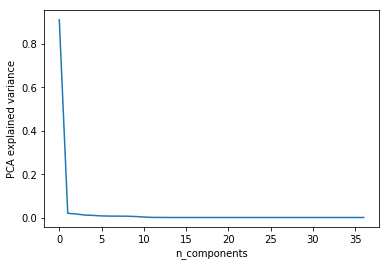

In [20]:
# PCA on training set
pca = decomposition.PCA().fit(X)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('PCA explained variance')
plt.xlabel('n_components')

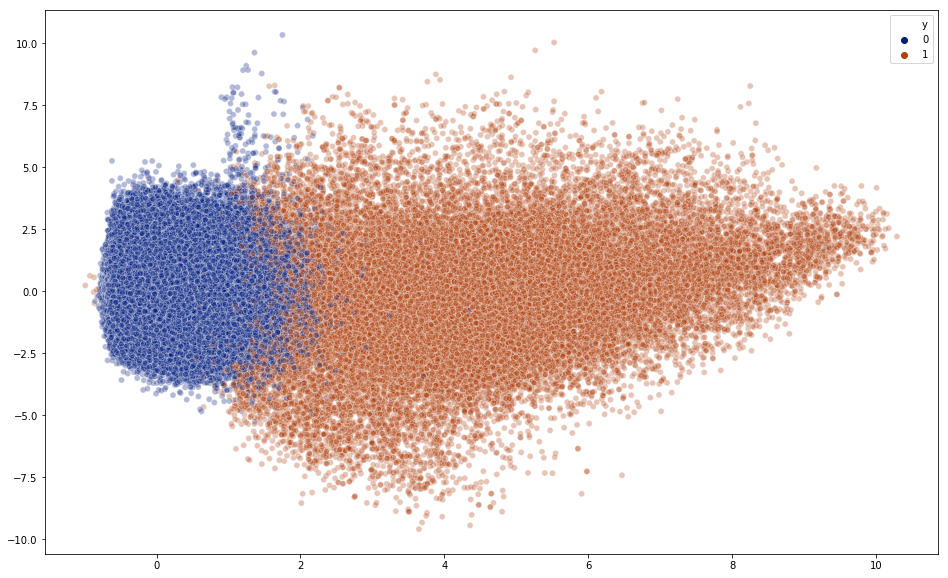

In [21]:
# So we chose 2 components and plot PCA result

pca = decomposition.PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(X)
pca_one = pca_result[:,0]
pca_two = pca_result[:,1] 

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_one, y=pca_two,
    hue=y['y'],
    palette=sns.color_palette("dark", 2),
    legend="full",
    alpha=0.3
)

#### The massive cluster is the "same" label because there is only one way images are the same while the "different" labels are much more sparse, indeed there are a lot of ways for images to be diffrent.

# The model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)

In [25]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [26]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'binary_logloss', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100}

In [27]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 100), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'max_bin': [10,100,300,500,700,1000],
             'objective': ['binary'],
             'is_unbalance' : [True]}

In [28]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [29]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0113396
[200]	valid's binary_logloss: 0.00799619
[300]	valid's binary_logloss: 0.00670365
[400]	valid's binary_logloss: 0.00599798
[500]	valid's binary_logloss: 0.00548873
[600]	valid's binary_logloss: 0.00513176
[700]	valid's binary_logloss: 0.0049226
[800]	valid's binary_logloss: 0.00475228
[900]	valid's binary_logloss: 0.00462441
[1000]	valid's binary_logloss: 0.00453023
[1100]	valid's binary_logloss: 0.00450215
Early stopping, best iteration is:
[1119]	valid's binary_logloss: 0.00449163
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0110072
[200]	valid's binary_logloss: 0.00775792
[300]	valid's binary_logloss: 0.00642133
[400]	valid's binary_logloss: 0.00574243
[500]	valid's binary_logloss: 0.00525224
[600]	valid's binary_logloss: 0.00495091
[700]	valid's binary_logloss: 0.00470206
[800]	valid's binary_logloss: 0.00455983
[900]	valid's binary_lo

[500]	valid's binary_logloss: 0.00529528
[600]	valid's binary_logloss: 0.00514515
[700]	valid's binary_logloss: 0.00502355
[800]	valid's binary_logloss: 0.00492551
[900]	valid's binary_logloss: 0.00485471
[1000]	valid's binary_logloss: 0.00481164
[1100]	valid's binary_logloss: 0.00476684
[1200]	valid's binary_logloss: 0.00472355
[1300]	valid's binary_logloss: 0.0046904
[1400]	valid's binary_logloss: 0.00466053
[1500]	valid's binary_logloss: 0.00464025
[1600]	valid's binary_logloss: 0.00462191
[1700]	valid's binary_logloss: 0.00460108
[1800]	valid's binary_logloss: 0.00457661
[1900]	valid's binary_logloss: 0.00456688
Early stopping, best iteration is:
[1905]	valid's binary_logloss: 0.00456572
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00939268
[200]	valid's binary_logloss: 0.00697555
[300]	valid's binary_logloss: 0.00607907
[400]	valid's binary_logloss: 0.00564389
[500]	valid's binary_logloss: 0.00537429
[600]	valid's binary_logloss: 0.0

[2000]	valid's binary_logloss: 0.0118487
[2100]	valid's binary_logloss: 0.0117902
[2200]	valid's binary_logloss: 0.0117298
[2300]	valid's binary_logloss: 0.0116812
[2400]	valid's binary_logloss: 0.0116222
[2500]	valid's binary_logloss: 0.0115628
[2600]	valid's binary_logloss: 0.0115078
[2700]	valid's binary_logloss: 0.0114549
[2800]	valid's binary_logloss: 0.0114145
[2900]	valid's binary_logloss: 0.0113789
[3000]	valid's binary_logloss: 0.0113343
[3100]	valid's binary_logloss: 0.0112969
[3200]	valid's binary_logloss: 0.0112522
[3300]	valid's binary_logloss: 0.0112166
[3400]	valid's binary_logloss: 0.0111828
[3500]	valid's binary_logloss: 0.0111557
[3600]	valid's binary_logloss: 0.0111334
[3700]	valid's binary_logloss: 0.0110981
[3800]	valid's binary_logloss: 0.0110704
[3900]	valid's binary_logloss: 0.0110451
[4000]	valid's binary_logloss: 0.0110204
[4100]	valid's binary_logloss: 0.0110001
[4200]	valid's binary_logloss: 0.0109773
[4300]	valid's binary_logloss: 0.0109525
[4400]	valid's b

[400]	valid's binary_logloss: 0.0445428
[500]	valid's binary_logloss: 0.043858
[600]	valid's binary_logloss: 0.0432396
[700]	valid's binary_logloss: 0.0427966
[800]	valid's binary_logloss: 0.0425257
[900]	valid's binary_logloss: 0.0421705
[1000]	valid's binary_logloss: 0.0418868
Early stopping, best iteration is:
[1005]	valid's binary_logloss: 0.0418764
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0102147
[200]	valid's binary_logloss: 0.0082103
[300]	valid's binary_logloss: 0.00772464
Early stopping, best iteration is:
[287]	valid's binary_logloss: 0.00772076
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0100891
[200]	valid's binary_logloss: 0.00814558
[300]	valid's binary_logloss: 0.00757601
Early stopping, best iteration is:
[299]	valid's binary_logloss: 0.00756961
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0101965
[200]	valid's binary_loglo

Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00649858
[200]	valid's binary_logloss: 0.00469317
[300]	valid's binary_logloss: 0.00440748
[400]	valid's binary_logloss: 0.00433009
Early stopping, best iteration is:
[420]	valid's binary_logloss: 0.00432176
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00648827
[200]	valid's binary_logloss: 0.0048925
[300]	valid's binary_logloss: 0.00463433
[400]	valid's binary_logloss: 0.00457345
Early stopping, best iteration is:
[391]	valid's binary_logloss: 0.00457144
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00632718
[200]	valid's binary_logloss: 0.00482452
[300]	valid's binary_logloss: 0.00455668
[400]	valid's binary_logloss: 0.00450941
Early stopping, best iteration is:
[370]	valid's binary_logloss: 0.00450263
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00645

[1300]	valid's binary_logloss: 0.0120724
[1400]	valid's binary_logloss: 0.0119876
[1500]	valid's binary_logloss: 0.0119084
[1600]	valid's binary_logloss: 0.0118149
[1700]	valid's binary_logloss: 0.0117236
[1800]	valid's binary_logloss: 0.0116554
[1900]	valid's binary_logloss: 0.0115819
[2000]	valid's binary_logloss: 0.0115205
[2100]	valid's binary_logloss: 0.0114493
[2200]	valid's binary_logloss: 0.0113901
[2300]	valid's binary_logloss: 0.0113334
[2400]	valid's binary_logloss: 0.0112791
[2500]	valid's binary_logloss: 0.0112113
[2600]	valid's binary_logloss: 0.0111568
[2700]	valid's binary_logloss: 0.0111073
[2800]	valid's binary_logloss: 0.0110585
[2900]	valid's binary_logloss: 0.0110216
[3000]	valid's binary_logloss: 0.010983
[3100]	valid's binary_logloss: 0.0109374
[3200]	valid's binary_logloss: 0.0109027
[3300]	valid's binary_logloss: 0.0108698
[3400]	valid's binary_logloss: 0.0108337
[3500]	valid's binary_logloss: 0.0108104
[3600]	valid's binary_logloss: 0.010773
[3700]	valid's bin

[200]	valid's binary_logloss: 0.0144158
[300]	valid's binary_logloss: 0.0137457
[400]	valid's binary_logloss: 0.0133773
[500]	valid's binary_logloss: 0.0131207
[600]	valid's binary_logloss: 0.0129351
[700]	valid's binary_logloss: 0.0127631
[800]	valid's binary_logloss: 0.012636
[900]	valid's binary_logloss: 0.0125075
[1000]	valid's binary_logloss: 0.0124104
[1100]	valid's binary_logloss: 0.0123053
[1200]	valid's binary_logloss: 0.0122151
[1300]	valid's binary_logloss: 0.0121263
[1400]	valid's binary_logloss: 0.0120307
[1500]	valid's binary_logloss: 0.0119348
[1600]	valid's binary_logloss: 0.0118669
[1700]	valid's binary_logloss: 0.0117784
[1800]	valid's binary_logloss: 0.0117142
[1900]	valid's binary_logloss: 0.0116542
[2000]	valid's binary_logloss: 0.011581
[2100]	valid's binary_logloss: 0.0115255
[2200]	valid's binary_logloss: 0.0114756
[2300]	valid's binary_logloss: 0.0114193
[2400]	valid's binary_logloss: 0.0113533
[2500]	valid's binary_logloss: 0.0112946
[2600]	valid's binary_logl

[300]	valid's binary_logloss: 0.00478726
[400]	valid's binary_logloss: 0.00450437
[500]	valid's binary_logloss: 0.00436911
[600]	valid's binary_logloss: 0.00428919
[700]	valid's binary_logloss: 0.0042553
[800]	valid's binary_logloss: 0.00423518
[900]	valid's binary_logloss: 0.00421898
Early stopping, best iteration is:
[882]	valid's binary_logloss: 0.00421679
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00766504
[200]	valid's binary_logloss: 0.00526367
[300]	valid's binary_logloss: 0.00458497
[400]	valid's binary_logloss: 0.00430763
[500]	valid's binary_logloss: 0.00419879
[600]	valid's binary_logloss: 0.00412116
[700]	valid's binary_logloss: 0.0040807
Early stopping, best iteration is:
[700]	valid's binary_logloss: 0.0040807
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0078618
[200]	valid's binary_logloss: 0.00544974
[300]	valid's binary_logloss: 0.00475381
[400]	valid's binary_logloss: 0.0

[2600]	valid's binary_logloss: 0.0113706
[2700]	valid's binary_logloss: 0.0113313
[2800]	valid's binary_logloss: 0.0112907
[2900]	valid's binary_logloss: 0.0112421
[3000]	valid's binary_logloss: 0.0112114
[3100]	valid's binary_logloss: 0.0111689
[3200]	valid's binary_logloss: 0.0111327
[3300]	valid's binary_logloss: 0.0111026
[3400]	valid's binary_logloss: 0.0110752
[3500]	valid's binary_logloss: 0.0110341
[3600]	valid's binary_logloss: 0.0110084
[3700]	valid's binary_logloss: 0.0109836
[3800]	valid's binary_logloss: 0.0109595
[3900]	valid's binary_logloss: 0.0109418
[4000]	valid's binary_logloss: 0.0109114
[4100]	valid's binary_logloss: 0.0108801
[4200]	valid's binary_logloss: 0.0108541
[4300]	valid's binary_logloss: 0.0108412
[4400]	valid's binary_logloss: 0.0108184
[4500]	valid's binary_logloss: 0.0107983
Early stopping, best iteration is:
[4550]	valid's binary_logloss: 0.0107792
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0167046
[20

Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0168055
[200]	valid's binary_logloss: 0.0152942
[300]	valid's binary_logloss: 0.0146882
[400]	valid's binary_logloss: 0.0142806
[500]	valid's binary_logloss: 0.0139864
[600]	valid's binary_logloss: 0.0137629
[700]	valid's binary_logloss: 0.0135834
[800]	valid's binary_logloss: 0.0134114
[900]	valid's binary_logloss: 0.0132828
[1000]	valid's binary_logloss: 0.0131606
[1100]	valid's binary_logloss: 0.0130598
[1200]	valid's binary_logloss: 0.0129556
[1300]	valid's binary_logloss: 0.0128668
[1400]	valid's binary_logloss: 0.0127702
[1500]	valid's binary_logloss: 0.0126913
[1600]	valid's binary_logloss: 0.0126238
[1700]	valid's binary_logloss: 0.0125519
[1800]	valid's binary_logloss: 0.0124905
[1900]	valid's binary_logloss: 0.0124192
[2000]	valid's binary_logloss: 0.0123611
[2100]	valid's binary_logloss: 0.0123098
[2200]	valid's binary_logloss: 0.0122498
[2300]	valid's binary_logloss: 0.012192
[2400]

[1100]	valid's binary_logloss: 0.00558519
[1200]	valid's binary_logloss: 0.00541674
[1300]	valid's binary_logloss: 0.00527386
[1400]	valid's binary_logloss: 0.00515171
[1500]	valid's binary_logloss: 0.00501154
[1600]	valid's binary_logloss: 0.00490147
[1700]	valid's binary_logloss: 0.00481421
[1800]	valid's binary_logloss: 0.00473677
[1900]	valid's binary_logloss: 0.00467583
[2000]	valid's binary_logloss: 0.00461599
[2100]	valid's binary_logloss: 0.00456126
[2200]	valid's binary_logloss: 0.00451326
[2300]	valid's binary_logloss: 0.00446347
[2400]	valid's binary_logloss: 0.00443562
[2500]	valid's binary_logloss: 0.00440552
[2600]	valid's binary_logloss: 0.00437973
[2700]	valid's binary_logloss: 0.00434321
[2800]	valid's binary_logloss: 0.00432039
[2900]	valid's binary_logloss: 0.00430032
[3000]	valid's binary_logloss: 0.00428416
[3100]	valid's binary_logloss: 0.00426864
Early stopping, best iteration is:
[3151]	valid's binary_logloss: 0.00425774
Training until validation scores don't im

[3200]	valid's binary_logloss: 0.0108046
[3300]	valid's binary_logloss: 0.0107796
[3400]	valid's binary_logloss: 0.0107499
[3500]	valid's binary_logloss: 0.0107234
[3600]	valid's binary_logloss: 0.0107003
[3700]	valid's binary_logloss: 0.0106808
[3800]	valid's binary_logloss: 0.0106582
[3900]	valid's binary_logloss: 0.0106342
[4000]	valid's binary_logloss: 0.0106104
[4100]	valid's binary_logloss: 0.0105895
[4200]	valid's binary_logloss: 0.0105647
[4300]	valid's binary_logloss: 0.0105489
[4400]	valid's binary_logloss: 0.0105337
[4500]	valid's binary_logloss: 0.0105182
[4600]	valid's binary_logloss: 0.0105013
[4700]	valid's binary_logloss: 0.010488
[4800]	valid's binary_logloss: 0.0104729
[4900]	valid's binary_logloss: 0.0104559
[5000]	valid's binary_logloss: 0.0104391
Did not meet early stopping. Best iteration is:
[4999]	valid's binary_logloss: 0.0104387
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0161347
[200]	valid's binary_logloss: 0.

[100]	valid's binary_logloss: 0.00708358
[200]	valid's binary_logloss: 0.0049755
[300]	valid's binary_logloss: 0.00447841
[400]	valid's binary_logloss: 0.00433444
[500]	valid's binary_logloss: 0.00429219
Early stopping, best iteration is:
[482]	valid's binary_logloss: 0.00428624
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00721842
[200]	valid's binary_logloss: 0.00514309
[300]	valid's binary_logloss: 0.00465699
[400]	valid's binary_logloss: 0.00453906
Early stopping, best iteration is:
[449]	valid's binary_logloss: 0.00450324
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0161968
[200]	valid's binary_logloss: 0.0146926
[300]	valid's binary_logloss: 0.0140907
[400]	valid's binary_logloss: 0.0136586
[500]	valid's binary_logloss: 0.0133606
[600]	valid's binary_logloss: 0.0131765
[700]	valid's binary_logloss: 0.0130099
[800]	valid's binary_logloss: 0.012859
[900]	valid's binary_logloss: 0.012757


[200]	valid's binary_logloss: 0.0045558
[300]	valid's binary_logloss: 0.00433196
Early stopping, best iteration is:
[354]	valid's binary_logloss: 0.00428899
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00592154
[200]	valid's binary_logloss: 0.00468572
[300]	valid's binary_logloss: 0.00446915
Early stopping, best iteration is:
[343]	valid's binary_logloss: 0.00442558
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0115791
[200]	valid's binary_logloss: 0.00925813
Early stopping, best iteration is:
[237]	valid's binary_logloss: 0.00904707
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0113405
[200]	valid's binary_logloss: 0.00898262
Early stopping, best iteration is:
[232]	valid's binary_logloss: 0.00876368
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0118029
[200]	valid's binary_logloss: 0.00937793
Early

[3600]	valid's binary_logloss: 0.0112058
[3700]	valid's binary_logloss: 0.0111845
[3800]	valid's binary_logloss: 0.0111471
[3900]	valid's binary_logloss: 0.0111268
[4000]	valid's binary_logloss: 0.0111018
[4100]	valid's binary_logloss: 0.0110766
[4200]	valid's binary_logloss: 0.0110497
[4300]	valid's binary_logloss: 0.0110294
[4400]	valid's binary_logloss: 0.0110096
[4500]	valid's binary_logloss: 0.0109917
[4600]	valid's binary_logloss: 0.0109689
[4700]	valid's binary_logloss: 0.0109492
[4800]	valid's binary_logloss: 0.0109355
Early stopping, best iteration is:
[4771]	valid's binary_logloss: 0.0109338
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.016736
[200]	valid's binary_logloss: 0.0151149
[300]	valid's binary_logloss: 0.0145452
[400]	valid's binary_logloss: 0.0141397
[500]	valid's binary_logloss: 0.0138424
[600]	valid's binary_logloss: 0.0136051
[700]	valid's binary_logloss: 0.0134048
[800]	valid's binary_logloss: 0.0131954
[900]	valid

Early stopping, best iteration is:
[4508]	valid's binary_logloss: 0.0108825
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00674974
[200]	valid's binary_logloss: 0.00500646
[300]	valid's binary_logloss: 0.0046907
[400]	valid's binary_logloss: 0.00464689
Early stopping, best iteration is:
[381]	valid's binary_logloss: 0.00464134
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00653136
[200]	valid's binary_logloss: 0.00480024
[300]	valid's binary_logloss: 0.00449177
[400]	valid's binary_logloss: 0.00445354
Early stopping, best iteration is:
[387]	valid's binary_logloss: 0.0044487
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00646915
[200]	valid's binary_logloss: 0.00474026
[300]	valid's binary_logloss: 0.0044033
[400]	valid's binary_logloss: 0.00433861
Early stopping, best iteration is:
[396]	valid's binary_logloss: 0.00433839
Training until validatio

[2700]	valid's binary_logloss: 0.011529
[2800]	valid's binary_logloss: 0.0114757
[2900]	valid's binary_logloss: 0.0114452
[3000]	valid's binary_logloss: 0.0114064
[3100]	valid's binary_logloss: 0.0113689
[3200]	valid's binary_logloss: 0.0113504
[3300]	valid's binary_logloss: 0.011311
[3400]	valid's binary_logloss: 0.0112843
[3500]	valid's binary_logloss: 0.0112595
[3600]	valid's binary_logloss: 0.0112341
[3700]	valid's binary_logloss: 0.0112046
[3800]	valid's binary_logloss: 0.0111815
[3900]	valid's binary_logloss: 0.0111531
[4000]	valid's binary_logloss: 0.0111358
[4100]	valid's binary_logloss: 0.0111141
[4200]	valid's binary_logloss: 0.0110814
[4300]	valid's binary_logloss: 0.011069
[4400]	valid's binary_logloss: 0.0110409
Early stopping, best iteration is:
[4407]	valid's binary_logloss: 0.011037
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0105855
[200]	valid's binary_logloss: 0.00813858
[300]	valid's binary_logloss: 0.00716942
[400]	v

Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00733653
[200]	valid's binary_logloss: 0.00530826
[300]	valid's binary_logloss: 0.00474261
[400]	valid's binary_logloss: 0.00451422
[500]	valid's binary_logloss: 0.00441573
Early stopping, best iteration is:
[492]	valid's binary_logloss: 0.00441375
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00748888
[200]	valid's binary_logloss: 0.00544766
[300]	valid's binary_logloss: 0.00486115
[400]	valid's binary_logloss: 0.00464675
[500]	valid's binary_logloss: 0.00454356
Early stopping, best iteration is:
[543]	valid's binary_logloss: 0.00453305
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0100217
[200]	valid's binary_logloss: 0.00852108
Early stopping, best iteration is:
[189]	valid's binary_logloss: 0.0085096
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.009704

[700]	valid's binary_logloss: 0.0130535
[800]	valid's binary_logloss: 0.0128792
[900]	valid's binary_logloss: 0.0127517
[1000]	valid's binary_logloss: 0.0126275
[1100]	valid's binary_logloss: 0.0124992
[1200]	valid's binary_logloss: 0.0123894
[1300]	valid's binary_logloss: 0.0122993
[1400]	valid's binary_logloss: 0.0122016
[1500]	valid's binary_logloss: 0.012113
[1600]	valid's binary_logloss: 0.0120247
[1700]	valid's binary_logloss: 0.0119455
[1800]	valid's binary_logloss: 0.0118592
[1900]	valid's binary_logloss: 0.0117995
[2000]	valid's binary_logloss: 0.0117388
[2100]	valid's binary_logloss: 0.0116774
[2200]	valid's binary_logloss: 0.0116189
[2300]	valid's binary_logloss: 0.0115485
[2400]	valid's binary_logloss: 0.0115013
[2500]	valid's binary_logloss: 0.0114437
[2600]	valid's binary_logloss: 0.0113804
[2700]	valid's binary_logloss: 0.0113439
[2800]	valid's binary_logloss: 0.0112922
[2900]	valid's binary_logloss: 0.011259
[3000]	valid's binary_logloss: 0.0112205
[3100]	valid's binary

[400]	valid's binary_logloss: 0.00433274
[500]	valid's binary_logloss: 0.00419468
[600]	valid's binary_logloss: 0.00414185
Early stopping, best iteration is:
[649]	valid's binary_logloss: 0.00412445
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00683874
[200]	valid's binary_logloss: 0.00510733
[300]	valid's binary_logloss: 0.00464481
[400]	valid's binary_logloss: 0.00449702
Early stopping, best iteration is:
[465]	valid's binary_logloss: 0.00444855
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00668444
[200]	valid's binary_logloss: 0.00483919
[300]	valid's binary_logloss: 0.00441853
[400]	valid's binary_logloss: 0.00428925
Early stopping, best iteration is:
[453]	valid's binary_logloss: 0.00424392
Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00674279
[200]	valid's binary_logloss: 0.0049611
[300]	valid's binary_logloss: 0.00453427
[400]	valid's bi

Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.015683
[200]	valid's binary_logloss: 0.0142099
[300]	valid's binary_logloss: 0.0136543
[400]	valid's binary_logloss: 0.0133092
[500]	valid's binary_logloss: 0.0130622
[600]	valid's binary_logloss: 0.0128461
[700]	valid's binary_logloss: 0.0126761
[800]	valid's binary_logloss: 0.012523
[900]	valid's binary_logloss: 0.0123983
[1000]	valid's binary_logloss: 0.0122743
[1100]	valid's binary_logloss: 0.0121636
[1200]	valid's binary_logloss: 0.0120458
[1300]	valid's binary_logloss: 0.0119338
[1400]	valid's binary_logloss: 0.0118394
[1500]	valid's binary_logloss: 0.0117554
[1600]	valid's binary_logloss: 0.0116764
[1700]	valid's binary_logloss: 0.011608
[1800]	valid's binary_logloss: 0.0115425
[1900]	valid's binary_logloss: 0.0114623
[2000]	valid's binary_logloss: 0.0114127
[2100]	valid's binary_logloss: 0.0113472
[2200]	valid's binary_logloss: 0.0112979
[2300]	valid's binary_logloss: 0.0112471
[2400]	v

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 209.2min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.00734062
[200]	valid's binary_logloss: 0.00494626
[300]	valid's binary_logloss: 0.00421552
[400]	valid's binary_logloss: 0.00390716
[500]	valid's binary_logloss: 0.00375049
[600]	valid's binary_logloss: 0.00368618
[700]	valid's binary_logloss: 0.00364742
Early stopping, best iteration is:
[763]	valid's binary_logloss: 0.00363915
Best score reached: 0.9988406685517014 with params: {'colsample_bytree': 0.4218095939560941, 'is_unbalance': True, 'max_bin': 500, 'min_child_samples': 451, 'min_child_weight': 1, 'num_leaves': 98, 'objective': 'binary', 'reg_alpha': 0, 'reg_lambda': 50, 'subsample': 0.8697665811080302} 


In [30]:
opt_parameters = {'colsample_bytree': 0.4218095939560941, 'is_unbalance': True, 'max_bin': 500, 'min_child_samples': 451, 'min_child_weight': 1, 'num_leaves': 98, 'objective': 'binary', 'reg_alpha': 0, 'reg_lambda': 50, 'subsample': 0.8697665811080302} 

In [31]:
#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X, y, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.0074081
[200]	valid's binary_logloss: 0.00471424
[300]	valid's binary_logloss: 0.00380604
[400]	valid's binary_logloss: 0.00338224
[500]	valid's binary_logloss: 0.00316287
[600]	valid's binary_logloss: 0.00303923
[700]	valid's binary_logloss: 0.00296965
[800]	valid's binary_logloss: 0.00293
[900]	valid's binary_logloss: 0.00290594
[1000]	valid's binary_logloss: 0.00288848
[1100]	valid's binary_logloss: 0.00287183
[1200]	valid's binary_logloss: 0.00285536
[1300]	valid's binary_logloss: 0.0028387
[1400]	valid's binary_logloss: 0.00282254
[1500]	valid's binary_logloss: 0.00280667
[1600]	valid's binary_logloss: 0.00279051
[1700]	valid's binary_logloss: 0.00277453
[1800]	valid's binary_logloss: 0.00275891
[1900]	valid's binary_logloss: 0.00274331
[2000]	valid's binary_logloss: 0.00272809
[2100]	valid's binary_logloss: 0.00271221
[2200]	valid's binary_logloss: 0.00269723
[2300]	valid's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.4218095939560941, importance_type='split',
        is_unbalance=True, learning_rate=0.1, max_bin=500, max_depth=-1,
        metric='None', min_child_samples=451, min_child_weight=1,
        min_split_gain=0.0, n_estimators=5000, n_jobs=4, num_leaves=98,
        objective='binary', random_state=314, reg_alpha=0, reg_lambda=50,
        silent=True, subsample=0.8697665811080302,
        subsample_for_bin=200000, subsample_freq=0)

In [32]:
X_sub = pd.read_csv('xtest_challenge.csv')
ypred = clf_final.predict(X_sub)


In [33]:
# Classify the provided test data
print(ypred.shape)
np.savetxt('ytest_challenge_student.csv', ypred, fmt = '%1.0d', delimiter=',')

(3318296,)


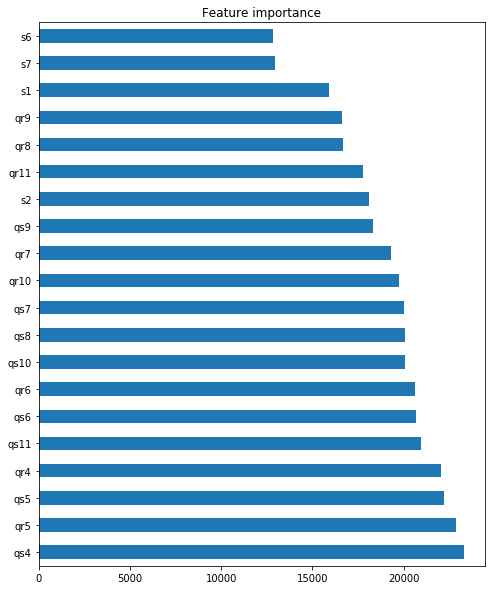

In [34]:
plt.title('Feature importance')
feat_imp = pd.Series(clf_final.feature_importances_, index=X.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))
